In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import utm
import numpy as np
import shapely

In [2]:
bath=pd.read_table('data/Drone+Bath/TRTS_2023_Bath_WGS84.csar.txt',names=['utm_x', 'utm_y', 'z'],delimiter= ',')
bath.z= np.abs(bath.z)
bath

,utm_x,utm_y,z
0,401067.0,7160726.0,115.02
1,401068.0,7160726.0,114.91
2,401069.0,7160726.0,114.79
3,401066.0,7160727.0,115.10
4,401067.0,7160727.0,115.01
...,...,...,...
144063,400953.0,7161726.0,111.95
144064,400951.0,7161727.0,112.00
144065,400952.0,7161727.0,111.97
144066,400953.0,7161727.0,111.94


In [20]:
Drone=pd.read_table('data/Drone+Bath/downsampled_2022.xyz',names=['x', 'y', 'z'], delimiter= ' ')
Drone.z[Drone.z==-32767.0]=np.NaN
utm_x_y = utm.from_latlon(
    Drone.y, 
    Drone.x, 
    6,'W'
    ) 
# Create a DataFrame from the points 
gps = [[x, y, z] for x, y, z in zip(utm_x_y[0], utm_x_y[1],Drone.z)]     
Drone_utm = pd.DataFrame(np.array(gps), columns= ['utm_x','utm_y','z'])
Drone_utm

,utm_x,utm_y,z
0,400650.358759,7.161691e+06,NaN
1,400650.608518,7.161691e+06,NaN
2,400650.858276,7.161691e+06,NaN
3,400651.108035,7.161691e+06,NaN
4,400651.357793,7.161691e+06,NaN
...,...,...,...
11482696,401396.210414,7.160744e+06,NaN
11482697,401396.460250,7.160744e+06,NaN
11482698,401396.710086,7.160744e+06,NaN
11482699,401396.959922,7.160744e+06,NaN


In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from descartes import PolygonPatch
from shapely.geometry import Point, MultiLineString, MultiPoint
from scipy.spatial import Delaunay
from shapely.ops import  polygonize, cascaded_union

def add_edge(edges, i, j):
    """
    Add a line between the i-th and j-th points,
    if not in the list already
    """        
    if (i, j) not in edges or (j, i) not in edges:    
        edges.add( (i, j) )
    return edges


def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    
    Parameters
    ----------
    points: array
        Iterable container of points.
    alpha: float
        alpha value to influence the length between 2 points at the border. 
        
    Returns
    -------
    cascaded_union(triangles): object
    
    """
    assert len(points) > 3, "Need at least four points"

    tri = Delaunay(points)
    edges = set()
    
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    i=0
    for ia, ib, ic in tri.simplices:
      pa = points[ia]
      pb = points[ib]
      pc = points[ic]
      # Lengths of sides of triangle
      a = np.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
      b = np.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
      c = np.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
      # Semiperimeter of triangle
      s = (a + b + c)/2.0
      # Area of triangle by Heron's formula
      area = np.sqrt(s*(s-a)*(s-b)*(s-c))
      circum_r = a*b*c/(4.0*area)
      # Radius filter.      
      if circum_r < 1.0/alpha:
          edges = add_edge(edges, ia, ib)
          edges = add_edge(edges, ib, ic)
          edges = add_edge(edges, ic, ia)

    edge_points = []
    pts = pd.Series(points)
    for idx in edges:
        pt0=pts[idx[0]]
        pt1=pts[idx[1]]
        edge_points.append([pt0, pt1])
    
    m = MultiLineString(edge_points)
    triangles = cascaded_union(list(polygonize(m)))

    return triangles

def plot_polygon(polygon):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3
    x_min, y_min, x_max, y_max = polygon.bounds
    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999',
                         ec='#000000', fill=True,
                         zorder=-1)
    ax.add_patch(patch)
    return fig

def apply_mask(triang, alpha=0.4):
    # Mask triangles with sidelength bigger some alpha
    triangles = triang.triangles
    # Mask off unwanted triangles.
    xtri = x[triangles] - np.roll(x[triangles], 1, axis=1)
    ytri = y[triangles] - np.roll(y[triangles], 1, axis=1)
    maxi = np.max(np.sqrt(xtri**2 + ytri**2), axis=1)
    # apply masking
    triang.set_mask(maxi > alpha)

In [11]:
points_3d = [(x,y) for x,y in zip(bath.utm_x, bath.utm_y)]
concave_hull_river = alpha_shape(points_3d, 0.05)

C:\Users\eabrowning\AppData\Local\Temp\ipykernel_22916\2048199601.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  circum_r = a*b*c/(4.0*area)
C:\Users\eabrowning\AppData\Local\Temp\ipykernel_22916\2048199601.py:71: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  triangles = cascaded_union(list(polygonize(m)))


In [13]:
#points_3d = [(x,y) for x,y in zip(Drone_utm.utm_x, Drone_utm.utm_y)]
#concave_hull = alpha_shape(points_3d, 0.05)

lat_polygon= [-149.07200,-149.06395,-149.05738,-149.06658,-149.07200,]
long_polygon=[64.56420, 64.56586, 64.55921, 64.55758, 64.56420]

In [17]:
points_3d = [(x,y) for x,y in zip(Drone_utm.utm_x, Drone_utm.utm_y)]
concave_hull = alpha_shape(points_3d, 0.05)

C:\Users\eabrowning\AppData\Local\Temp\ipykernel_22916\2048199601.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  circum_r = a*b*c/(4.0*area)
C:\Users\eabrowning\AppData\Local\Temp\ipykernel_22916\2048199601.py:55: RuntimeWarning: invalid value encountered in sqrt
  area = np.sqrt(s*(s-a)*(s-b)*(s-c))
C:\Users\eabrowning\AppData\Local\Temp\ipykernel_22916\2048199601.py:71: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  triangles = cascaded_union(list(polygonize(m)))


In [22]:
utm_x_y = utm.from_latlon(
    long_polygon, 
    lat_polygon, 
    6,'W'
    ) 
utm_polygon_coords = [[x, y] for x, y in zip(utm_x_y[0], utm_x_y[1])]  


In [24]:
polygon = shapely.Polygon(utm_polygon_coords)


In [27]:

combined = shapely.intersection(polygon, concave_hull_river, grid_size=1)

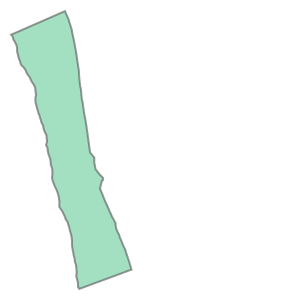

In [28]:
combined

In [29]:
banks=shapely.difference(polygon, concave_hull_river, grid_size=0.05)

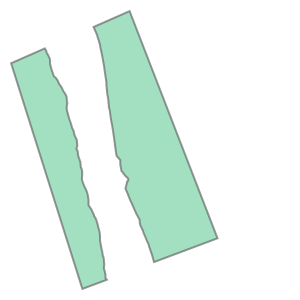

In [30]:
banks

In [31]:
bathimity = bath.to_numpy()
bathimity
Bath_shape = shapely.MultiPoint(bathimity)

In [32]:
river_mask=shapely.contains_xy(combined,bathimity)

In [33]:
bathimity = bath.to_numpy()
bathimity

array([[4.010670e+05, 7.160726e+06, 1.150200e+02],
       [4.010680e+05, 7.160726e+06, 1.149100e+02],
       [4.010690e+05, 7.160726e+06, 1.147900e+02],
       ...,
       [4.009520e+05, 7.161727e+06, 1.119700e+02],
       [4.009530e+05, 7.161727e+06, 1.119400e+02],
       [4.009520e+05, 7.161728e+06, 1.119200e+02]])

In [36]:
shore_mask= shapely.contains_xy(banks,Drone_utm)

In [43]:
np.size(shore_mask)

11482701

In [37]:

Drone_utm[shore_mask]

,utm_x,utm_y,z
1789,401097.177775,7.161676e+06,115.676323
1790,401097.427534,7.161676e+06,115.682419
1791,401097.677294,7.161676e+06,115.688507
1792,401097.927054,7.161676e+06,115.694321
1793,401098.176813,7.161676e+06,115.700134
...,...,...,...
11418701,400952.915079,7.160763e+06,119.337418
11421807,400951.657766,7.160763e+06,119.343727
11421808,400951.907601,7.160763e+06,119.342857
11421809,400952.157435,7.160763e+06,119.341797


In [38]:
#plt.figure(figsize=(10,4.4))
#contour_plot = plt.tripcolor(
#    gps_points[shore_mask].utm_x, 
#    gps_points[shore_mask].utm_y, 
#    gps_points[shore_mask].z
#    )

plt.figure(figsize=(10,4.4))
contour_plot = plt.tripcolor(
   bath[river_mask].x, 
   bath[river_mask].y, 
   bath[river_mask].z
    )

In [39]:
Tanana= pd.concat([bath[river_mask],Drone_utm[shore_mask]])

In [40]:
Tanana

,utm_x,utm_y,z
4866,401032.000000,7.160794e+06,114.620000
4867,401033.000000,7.160794e+06,114.240000
4868,401034.000000,7.160794e+06,113.620000
5015,401031.000000,7.160795e+06,114.390000
5016,401032.000000,7.160795e+06,114.350000
...,...,...,...
11418701,400952.915079,7.160763e+06,119.337418
11421807,400951.657766,7.160763e+06,119.343727
11421808,400951.907601,7.160763e+06,119.342857
11421809,400952.157435,7.160763e+06,119.341797


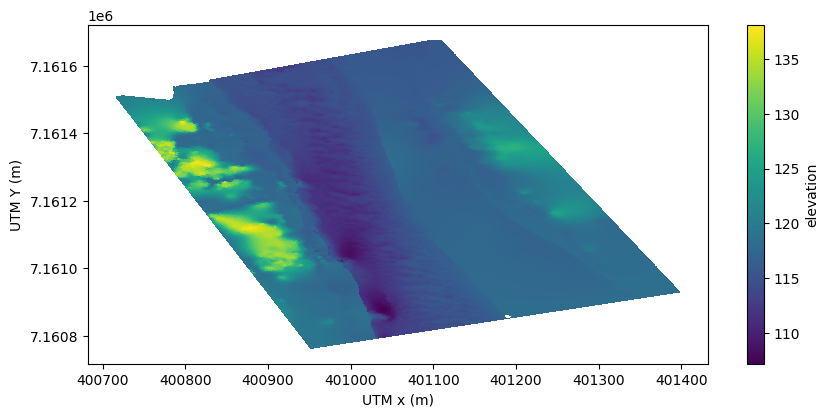

In [42]:
plt.figure(figsize=(10,4.4))
contour_plot = plt.tripcolor(
   Tanana.utm_x, 
   Tanana.utm_y, 
   Tanana.z
    )
plt.xlabel('UTM x (m)')
plt.ylabel('UTM Y (m)')
cbar= plt.colorbar(contour_plot)
cbar.set_label('elevation (m)')

In [43]:
Tanana.to_csv('trts_2022_2023.xyz',sep= ' ', index=False)